# 0. 문제 설명
효율적인 SNS 광고 타겟을 잡기 위해 광고타겟의 나이라는 피쳐를 통하여 어떤 나이가 주로 SNS를 많이 이용하는지 궁금하여 분석을 진행하게 됨

따라서 공공데이터포털에서 한국미디어패널조사의 rawdata를 다운받아 분석을 진행

feature는 이용시간과 나이를 대상으로 할 에정

해당 데이터는 코드북을 확인하여야 컬럼의 이름이 무슨 데이터인지 알 수 있기 때문에 코드북을 따로 확인하며 진행

해당 파일은 서술하며 설명

# 1. 기본 실행파일


In [1]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics

In [4]:
df = pd.read_csv("./p23v30_KMP_csv.csv", encoding='cp949') 
# UTF-8이 아니고 cp949 인코딩
df.head()

/tmp/ipykernel_5288/3574233097.py:1: DtypeWarning: Columns (5,508) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./p23v30_KMP_csv.csv", encoding='cp949')


,pid,hid,housenum,p23wt,p23wt2,p23wt_org,p23wt_org2,KMPS10,KMPS11,KMPS19,...,p23k06001,p23k06002,p23k06003,p23k06004,p23k06005,p23k03001,p23k03002,p23k03003,p23k07001,p23k07002
0,10001,100,1,0.079204,.134900429500422,0.229259,2.0867587611946,,1,,...,3,2,,,,1,2,8,4,4
1,10002,100,2,0.077611,.1198459955419,0.225981,1.41678521930361,,1,,...,3,2,,,,12,8,1,4,4
2,10003,100,3,0.105292,,0.349857,,,1,,...,3,1,3,,2,13,1,3,4,3
3,10004,100,4,0.100181,,0.319221,,,1,,...,3,2,,,,3,6,10,3,3
4,20001,200,1,1.768926,2.24682939382758,1.971497,,,1,,...,3,2,,,,2,12,13,4,3


# 2. 데이터 전처리

보면 feature가 상당히 많다. 먼저 대상으로 하는 나이 데이터와 시간 데이터를 확인

여기서 나이 데이터는 p23age1

나이대 데이터는 p23age

나이대의 분류는

1: 만 10세 미만

2: 만 10-19세

3: 만 20-29세

4: 만 30-39세

5: 만 40-49세

6: 만 50-59세

7: 만 60-69세

8: 만 70세 이상

시간 데이터는 단위가 분으로 되어 있으며

주중 평균 이용시간 p23d11010

주말 평균 이용시간 p23d11014
             
총 3종류 컬럼이 존재

In [5]:
print(df['p23d11010'].dtype,df['p23d11014'].dtype,df['p23age1'].dtype,df['p23age'].dtype)

object object object int64


In [6]:
# 현재 데이터 타입이 3개가 object인 것을 확인
df.replace(r'^\s*$', np.nan, regex=True, inplace=True) #먼저 데이터 파일에 있는 공백을 결측치로 바꾸는 작업
# 문자열을 숫자로 변환하고, 변환이 불가능한 경우 NaN으로 대체
df['p23d11010'] = pd.to_numeric(df['p23d11010'], errors='coerce')# 오류를 NaN으로 설정
df['p23d11014'] = pd.to_numeric(df['p23d11014'], errors='coerce')
df['p23age1'] = pd.to_numeric(df['p23age1'], errors='coerce')

/tmp/ipykernel_5288/2239502647.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(r'^\s*$', np.nan, regex=True, inplace=True) #먼저 데이터 파일에 있는 공백을 결측치로 바꾸는 작업


In [7]:
#나이 데이터 확인
print(df[['pid']].count()) #전체 데이터 갯수 확인하기
print('---------------------------------')
print(df[['p23age1']].count())
# 나이 컬럼에 있는 데이터의 수 확인
print('---------------------------------')
missing_count_age = df[['p23age1']].isnull().sum()[0]
zero_count_age= (df['p23age1'] == 0).sum()
print('결측치의 갯수는 %d 입니다. 0으로 입력된 칸은 %d개 입니다' % (missing_count_age, zero_count_age))
# 결측치의 갯수를 합한 수치
print('---------------------------------')

pid    9757
dtype: int64
---------------------------------
p23age1    9411
dtype: int64
---------------------------------
결측치의 갯수는 346 입니다. 0으로 입력된 칸은 0개 입니다
---------------------------------


/tmp/ipykernel_5288/2667263055.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  missing_count_age = df[['p23age1']].isnull().sum()[0]


In [8]:
#시간 데이터 확인
# 주중 평균 이용시간에 있는 데이터의 수 확인
print(df[['p23d11010']].count())
print('---------------------------------')
# 주말 평균 이용시간에 있는 데이터의 수 확인
print(df[['p23d11014']].count())
# 결측치의 갯수를 합한 수치
missing_count_weekday = df[['p23d11010']].isnull().sum()
zero_count_weekday= (df['p23d11010'] == 0).sum()
print('주중 평균 이용시간 데이터의 결측치 갯수는 %d 입니다. 0으로 입력된 칸은 %d개 입니다' % (missing_count_weekday, zero_count_weekday))
missing_count_weekend=df[['p23d11014']].isnull().sum()
zero_count_weekend=df[['p23d11014']].isnull().sum()
print('주말 평균 이용시간 데이터의 결측치 갯수는 %d 입니다. 0으로 입력된 칸은 %d개 입니다' % (missing_count_weekend, zero_count_weekend))

p23d11010    5343
dtype: int64
---------------------------------
p23d11014    5343
dtype: int64
주중 평균 이용시간 데이터의 결측치 갯수는 4414 입니다. 0으로 입력된 칸은 28개 입니다
주말 평균 이용시간 데이터의 결측치 갯수는 4414 입니다. 0으로 입력된 칸은 4414개 입니다


/tmp/ipykernel_5288/3427550039.py:10: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print('주중 평균 이용시간 데이터의 결측치 갯수는 %d 입니다. 0으로 입력된 칸은 %d개 입니다' % (missing_count_weekday, zero_count_weekday))
/tmp/ipykernel_5288/3427550039.py:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print('주말 평균 이용시간 데이터의 결측치 갯수는 %d 입니다. 0으로 입력된 칸은 %d개 입니다' % (missing_count_weekend, zero_count_weekend))


해당 데이터를 확인해보면 결측치가 4414개로 측정되며 왜 이런 많은 결측치가 나오는지 확인해보자

SNS 이용자와 이용하지 않은 대상이 있기에 발생한 결과라는 점을 발견

따라서 SNS 이용여부를 확인하는 열까지 추가로 조사

SNS 이용 여부 컬럼은 p23d11001 이고 이용여부 긍정과 부정을 각각 1과 2로 표현

In [9]:
print(df[['p23d11001']].count())
count_sns_user=(df['p23d11001']==1).sum()
count_non_sns_user=(df['p23d11001']==2).sum()
print('SNS 사용자(1): %d' % count_sns_user)
print('SNS 미사용자(2): %d'% count_non_sns_user)

p23d11001    9757
dtype: int64
SNS 사용자(1): 5343
SNS 미사용자(2): 4414


해당 결과에 따라 SNS 사용자 5343명을 대상으로 다시 나이를 분석해야하는 결과가 도출

새로운 데이터프레임을 짜놓을지 아니면 필요없는 데이터를 삭제할지 고민하다가

필자는 미사용자들 모두 drop 하는 과정을 실행

In [10]:
index_to_drop = df[df['p23d11001'] == 2].index # 드롭하여야 하는 데이터 찾아서 변수로 할당
df.drop(index_to_drop, inplace=True) # 데이터 드롭
print(df[['p23d11001']].count())
print('SNS 미사용자(2)가 제거된 후의 행 수:', len(df))

p23d11001    5343
dtype: int64
SNS 미사용자(2)가 제거된 후의 행 수: 5343


나이 데이터 재확인

In [12]:
#나이 데이터 재확인
print(df[['pid']].count()) #전체 데이터 갯수 확인하기
print('---------------------------------')
print(df[['p23age1']].count())
# 나이 컬럼에 있는 데이터의 수 확인
print('---------------------------------')
missing_count_age = df[['p23age1']].isnull().sum()[0]
zero_count_age= (df['p23age1'] == 0).sum()
print('결측치의 갯수는 %d 입니다. 0으로 입력된 칸은 %d개 입니다' % (missing_count_age, zero_count_age))


pid    5343
dtype: int64
---------------------------------
p23age1    5130
dtype: int64
---------------------------------
결측치의 갯수는 213 입니다. 0으로 입력된 칸은 0개 입니다


/tmp/ipykernel_5288/1293989731.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  missing_count_age = df[['p23age1']].isnull().sum()[0]


나이데이터의 결측치의 경우 나이대는 표시되어 있지만 정확한 나이가 기입되어 있지 않음.

해당 나이대의 중앙값 혹은 평균 값으로 결측치를 채우는 방법 중 필자는 나이대의 평균값으로 결정.

10대 미만의 경우에는 중앙값이 5인데 5세부터 스마트폰을 사용하는 경우는 적을 거라고 생각한 연구자 주관적 판단

In [13]:
#==========================================================================

# non_age_row=df[df['p23age1'].isnull()]# 결측치 데이터 프레임 생성
# age_1_rows = df[df['p23age'] == 1]#나이대 변수가 1인 데이터를 모아놓은 데이터프레임 생성
# average_age1 = age_1_rows['p23age1'].mean()#나이대 1의 평균값 생성
# # fillna메서드를 이용하여 결측치 재우기
# age_1_rows['p23age1'].fillna(average_age1, inplace=True)

In [14]:
#1~8까지 적용
for i in range(1, 9):
    # 나이대가 i인 행들을 선택합니다.
    age_rows = df[df['p23age'] == i]
    # 해당 나이대의 평균을 계산합니다. 결측치를 제외하고 평균을 계산합니다.
    mean_age = age_rows['p23age1'].mean(skipna=True)
    # 원본 데이터프레임에서 나이대가 i인 행들의 결측치를 채웁니다.
    df.loc[df['p23age'] == i, 'p23age1'] = age_rows['p23age1'].fillna(mean_age)

In [17]:
# 결측치 갯수 재할당 및 결측치 갯수 확인
missing_count_age = df[['p23age1']].isnull().sum()[0]
zero_count_age= (df['p23age1'] == 0).sum()
print('결측치의 갯수는 %d 입니다. 0으로 입력된 칸은 %d개 입니다' % (missing_count_age, zero_count_age))

결측치의 갯수는 0 입니다. 0으로 입력된 칸은 0개 입니다


/tmp/ipykernel_5288/3355159690.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  missing_count_age = df[['p23age1']].isnull().sum()[0]


적용이 모두 된 것을 확인

In [18]:
# non_age_row=df[df['p23age1'].isnull()]# 결측치 데이터 프레임 생성
# print(non_age_row[['pid']])

시간데이터 재확인

In [19]:
#시간 데이터 재확인
# 주중 평균 이용시간에 있는 데이터의 수 확인
print(df[['p23d11010']].count())
print('---------------------------------')
# 주말 평균 이용시간에 있는 데이터의 수 확인
print(df[['p23d11014']].count())
# 결측치의 갯수를 합한 수치
missing_count_weekday = df[['p23d11010']].isnull().sum()
zero_count_weekday= (df['p23d11010'] == 0).sum()
print('주중 평균 이용시간 데이터의 결측치 갯수는 %d 입니다. 0으로 입력된 칸은 %d개 입니다' % (missing_count_weekday, zero_count_weekday))
missing_count_weekend=df[['p23d11014']].isnull().sum()
zero_count_weekend=df[['p23d11014']].isnull().sum()
print('주말 평균 이용시간 데이터의 결측치 갯수는 %d 입니다. 0으로 입력된 칸은 %d개 입니다' % (missing_count_weekend, zero_count_weekend))

print(df['p23d11014'])

p23d11010    5343
dtype: int64
---------------------------------
p23d11014    5343
dtype: int64
주중 평균 이용시간 데이터의 결측치 갯수는 0 입니다. 0으로 입력된 칸은 28개 입니다
주말 평균 이용시간 데이터의 결측치 갯수는 0 입니다. 0으로 입력된 칸은 0개 입니다
0       10.0
1       10.0
2       30.0
3       30.0
4       10.0
        ... 
9745    60.0
9747    60.0
9750     5.0
9751    10.0
9752    60.0
Name: p23d11014, Length: 5343, dtype: float64


/tmp/ipykernel_5288/3361861842.py:10: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print('주중 평균 이용시간 데이터의 결측치 갯수는 %d 입니다. 0으로 입력된 칸은 %d개 입니다' % (missing_count_weekday, zero_count_weekday))
/tmp/ipykernel_5288/3361861842.py:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print('주말 평균 이용시간 데이터의 결측치 갯수는 %d 입니다. 0으로 입력된 칸은 %d개 입니다' % (missing_count_weekend, zero_count_weekend))


### 시간 데이터는 주말과 주중으로 나뉘어 있음

따라서 필자는 주중 데이터에 5를 곱하고 주말 데이터에 2를 곱한 다음 모두 합산해서 한 주간 이용시간을 유추한 데이터프레임을 만드려고 함

In [20]:
# 새로운 데이터프레임 생성
df['usetime'] = df['p23d11010']*5 + df['p23d11014'] * 2
print(df[['usetime']])

      usetime
0        70.0
1        70.0
2       210.0
3       210.0
4        95.0
...       ...
9745    270.0
9747    420.0
9750     10.0
9751     70.0
9752    420.0

[5343 rows x 1 columns]


/tmp/ipykernel_5288/860680515.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['usetime'] = df['p23d11010']*5 + df['p23d11014'] * 2


### 데이터간 상관관계 분석

# 3. 데이터 분석

In [21]:
X = df.loc[:, ['usetime']]
y = df['p23age1']

In [22]:
nclusters = 8 #나이대를 8구간 정도로 나누어서 1~8까지 분류 기존 수업 내용에서 elbow를 하지 않은 방식
seed = 0

km = KMeans(n_clusters=nclusters, random_state=seed)
km.fit(X)


y_cluster_kmeans = km.predict(X)
y_cluster_kmeans


array([0, 0, 5, ..., 0, 0, 3], dtype=int32)

In [23]:
# 클러스터링 실루엣 점수 평가
score = metrics.silhouette_score(X, y_cluster_kmeans)
score

0.6369991386050352

# 엘보우 방식과 WCSS를 사용한 방식

In [24]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

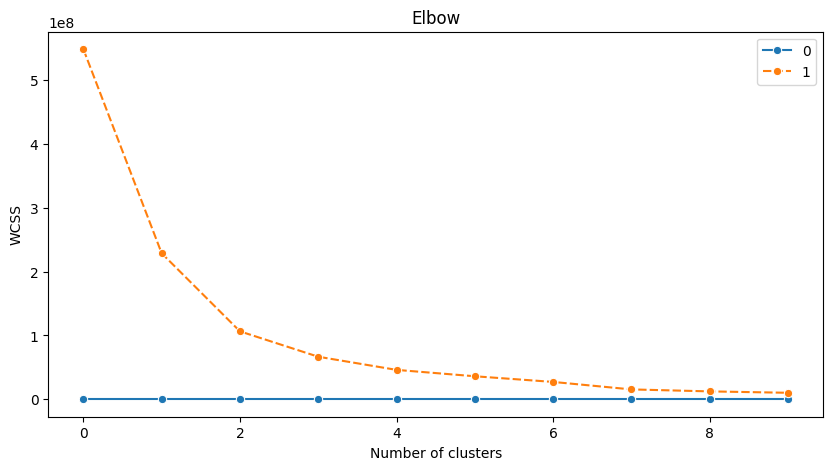

In [25]:
plt.figure(figsize=(10,5))
sns.lineplot(data=(range(1, 11), wcss), marker='o', color='red')
plt.title('Elbow')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

가장 WCSS 값의 변동 값이 적어지는 구간인 3이 가장 적절한 K값으로 나타나고 있음

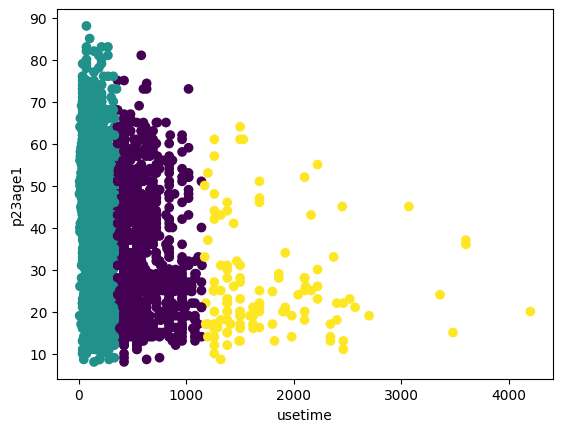

In [26]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(X)
labels = kmeans.predict(X)
plt.scatter(df['usetime'],df['p23age1'],c = labels)
plt.xlabel('usetime')
plt.ylabel('p23age1')
plt.show()

In [27]:
# KMeans 클러스터링 모델을 초기화하고 학습
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df[['p23age1', 'usetime']])
# 클러스터의 중심점을 출력
centers = kmeans.cluster_centers_
print("클러스터 중심점:\n", centers)
# 각 중심점에 대한 데이터프레임을 생성
# centers_df = pd.DataFrame(centers, columns=['p23age1', 'usetime'])
# print(centers_df)

클러스터 중심점:
 [[  42.05397221  150.29142714]
 [  26.14909876 1731.48031496]
 [  33.23486846  577.60082305]]


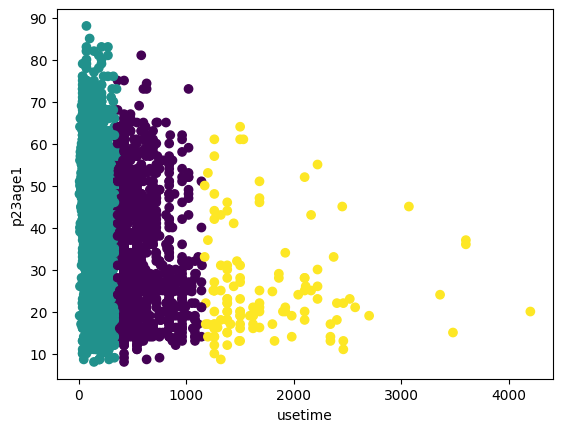

위에 그래프를 확인하면 빗변이 오른쪽으로 내려가는 직각삼각형의 모양을 띄고 있다.

초록색은 0, 보라색은 2, 노란색은 1에 해당하는 중심점을 가지고 있다.

산점도 그래프에 따르면 밀집이 가장 높은 곳은 초록색과 보라색 구간이며 노란색의 경우 밀짚도가 낮고 이용시간이 대부분 높은 것을 확인가능하다

중심점을 대상으로 비교를 하면 0이 가장 나이가 많으며 이용시간도 짧은 것을 확인가능하다.

1번 같은 경우에는 나이가 가장 젊고 이용시간이 매우 높다.

또한 밀짚도가 주로 10~30사이의 나이에서 가장 높은 결과를 보여주고 있다

2번 같은 경우는 그 사이 중간 정도의 값을 가지고 있다. 

그래프에 대해 정리하자면 SNS 이용시간이 가장 긴 이용자는 주로 10~30 대의 사람들이며 나이가 많아질수록 SNS 이용시간 자체는 짧아지는 경향을 보이고 있다. 하지만 대부분의 SNS 이용자들이 밀짚되어 있는 구간이 일주일 기준 16~17시간(1000분) 이하인 것을 확인해보면 불특정 다수를 타겟으로 하는 SNS 광고는 타겟팅의 난점이 없다는 분석 또한 나온다.

따라서 SNS 이용시간에 따른 클러스터링에 의하면 SNS 광고의 타깃은 10~30대가 가장 적절하며 나이가 많아 질수록 SNS의 이용시간은 짧아지기 때문에 효율성은 떨어진다고 예측된다. 하지만 밀집도를 확인해보면 시간이 길어질수록 밀집도가 떨어진다는 점이 확인되기에 10~30대를 타깃으로 하는 SNS 광고의 효용성이 극적으로 높지 않을 수 있음 또한 명심해야 한다.

In [28]:
nclusters = 3 # 이번에는 엘보우 방식으로 결정한 3을 입력
seed = 0

km = KMeans(n_clusters=nclusters, random_state=seed)
km.fit(X)


y_cluster_kmeans = km.predict(X)
y_cluster_kmeans
score = metrics.silhouette_score(X, y_cluster_kmeans)
score

0.6895403421422328

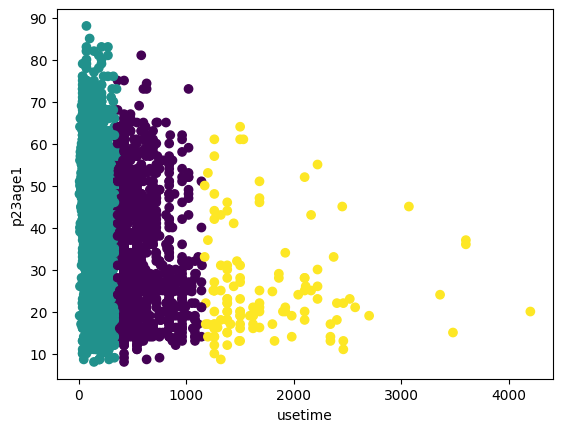


실루엣 스코어의 ncluster를 엘보우 방식으로 측정 후 변환한 후 결과

0.05 정도 정확도가 더 상승한 결과를 보이고 있다

기존 8에서 3으로 낮추었을 때 클러스터간 분리가 더 잘되었다. 다만 특정 구간에 대부분의 표본들이 밀짚되어 있고 노란색의 클러스터를 보면 알 수 있듯이 밀짚도가 매우 낮은 부분이 존재하기에 그리 극적인 차이가 없음 또한 보여주고 있다.